## Setup

In [1]:
import networkx as nx
from networkx.algorithms import bipartite

import itertools
import random
from math import ceil
from math import fsum
import math

from time import perf_counter
# from tqdm.notebook import trange, tqdm
from tqdm import trange, tqdm

# import matplotlib as mpl
import matplotlib.pyplot as plt

## Utility functions

In [2]:
def draw_edge_set(G, edges):
    colors = []
    for (u,v) in G.edges:
        if (u,v) in edges or (v,u) in edges:
            colors.append("red")
        else:
            colors.append("black")

    nx.draw_networkx(G, edge_color=colors)

In [3]:
def contract(u, v, orientations):
    if orientations == (0,0):
        return tuple(reversed(u)) + v
    elif orientations == (0,-1):
        return tuple(reversed(u)) + tuple(reversed(v))
    elif orientations == (-1,0):
        return u + v
    elif orientations == (-1,-1):
        return u + tuple(reversed(v))
    else:
        raise ValueError("invalid orientations")

def orient(G, u, v):
    oris_list = [(0,0), (0,-1), (-1,0), (-1,-1)]
    u_ori, v_ori = max(oris_list, key = lambda oris: G.edges[u[oris[0]],v[oris[1]]]['weight'])
    return (u_ori, v_ori), G.edges[u[u_ori],v[v_ori]]['weight']

In [4]:
def info(string, verbose):
    if verbose:
        print(f"%%% {string} %%%")

In [5]:
def avg(Ns):
    return fsum(Ns) / len(Ns)

def neutrality(G, path, agg):
    Ns = []
    for u,v in zip(path, path[1:]):
        Ns.append(G.edges[u,v]['weight'])
    return agg(Ns)

## Solvers

In [6]:
def _via_brute_force(G, n, verbose, agg):
    path = tuple(range(n))
    neut_max = 0
    for p in itertools.permutations(range(n)):
        neut = neutrality(G, p, agg)
        if neut > neut_max:
            path = p
            neut_max = neut
    return path

In [7]:
def via_brute_force_avg_agg(G, n, verbose=False):
    return _via_brute_force(G, n, verbose, avg)

def via_brute_force_min_agg(G, n, verbose=False):
    return _via_brute_force(G, n, verbose, min)

### avg aggregation

In [8]:
def via_matching(G, n, verbose=False):
    matching = nx.max_weight_matching(G)

    path = []
    for u,v in matching:
        path.append(u)
        path.append(v)
    if n % 2 == 1:
        vertex_sum = n * (n-1) / 2
        final_v = int(vertex_sum - sum(path))
        path.append(final_v)
    
    return tuple(path)

In [9]:
def via_iterated_matching(G, n, verbose=False):
    Gk = nx.complete_graph([(i,) for i in range(n)])
    for u in Gk.nodes:
        Gk.nodes[u]['value'] = u[0]  # value is used to efficiently find final vertex when cardinality is odd
    for u,v in Gk.edges:
        Gk.edges[u,v]['orientations'] = (-1,0)
        Gk.edges[u,v]['weight'] = G.edges[u[-1],v[0]]['weight']

    num_nodes = n
    while num_nodes > 1:
        info(f"num nodes: {num_nodes}", verbose)
        
        Gk_old = Gk
        Gk = nx.Graph()

        matching = nx.max_weight_matching(Gk_old)

        if num_nodes % 2 == 1:
            value_sum = n * (n-1) / 2
            for u,v in matching:
                value_sum -= Gk_old.nodes[u]['value'] + Gk_old.nodes[v]['value']
            final_value = int(value_sum)
            for u in Gk_old.nodes:
                if Gk_old.nodes[u]['value'] == final_value:
                    fluke = False
                    for x,y in matching:
                        if u in (x,y):
                            fluke = True
                    if not fluke:
                        Gk.add_node(u)
                        Gk.nodes[u]['value'] = final_value

        for u,v in matching:
            node = contract(u, v, Gk_old.edges[u,v]['orientations'])
            Gk.add_node(node)
            Gk.nodes[node]['value'] = Gk_old.nodes[u]['value'] + Gk_old.nodes[v]['value']

        for u in Gk.nodes:
            for v in Gk.nodes:
                if u != v:
                    oris, w = orient(G, u, v)
                    Gk.add_edge(u, v, orientations=oris, weight=w)

        num_nodes = len(Gk.nodes)

    for u in Gk.nodes:
        assert Gk.nodes[u]['value'] == n * (n-1) / 2

    return next(iter(Gk.nodes))

WARNING: NetworkX uses an assignment problem solver other than the Hungarian method

In [10]:
def via_cycle_cover(G, n, verbose=False):
    Gb = nx.Graph()
    for i in range(2*n):
        Gb.add_node(i)
    for u,v in G.edges:
        Gb.add_edge(u, v+n, weight=1-G.edges[u,v]['weight'])  # account for min weight NetworkX method
        Gb.add_edge(v, u+n, weight=1-G.edges[u,v]['weight'])  # account for min weight NetworkX method

    mb_dict = bipartite.minimum_weight_full_matching(Gb, top_nodes=list(Gb.nodes)[:n])
    # draw_edge_set(Gb, list(mb_dict.items()))

    m_dict = {}
    for u,v in mb_dict.items():
        if u < n:
            x,y = u,v
        else:
            x,y = v,u
        m_dict[x] = y-n
    # draw_edge_set(G, list(m_dict.items()))


    cycle_cover = []

    done = set()
    cycle = []
    start = curr = 0

    while True:
        cycle.append(curr)
        done.add(curr)
        curr = m_dict[curr]
        if curr == start:
            cycle_cover.append(cycle)
            cycle = []
            flag = False
            for i in range(n):
                if i not in done:
                    start = curr = i
                    flag = True
                    break
            if not flag:
                break

    path_cover = []
    for cycle in cycle_cover:
        best_start = cycle[0]
        best_start_idx = 0
        min_weight = G.edges[cycle[-1],cycle[0]]['weight']
        for i, (u,v) in enumerate(zip(cycle, cycle[1:])):
            if G.edges[u,v]['weight'] < min_weight:
                best_start = v
                best_start_idx = i+1
                min_weight = G.edges[u,v]['weight']
        path = cycle[best_start_idx:] + cycle[:best_start_idx]
        path_cover.append(path)

    return tuple(itertools.chain(*path_cover))

In [11]:
def via_iterated_cycle_cover(G, n, verbose=False):
    Gk = nx.complete_graph([(i,) for i in range(n)])
    num_nodes = n  
    
    while num_nodes > 1:
        info(f"num nodes: {num_nodes}", verbose)
        
        Gb = nx.Graph()
        for u in Gk.nodes:
            Gb.add_node(u)
            Gb.add_node(tuple([i + n for i in u]))
        for u,v in Gk.edges:
            Gb.add_edge(u, tuple([i + n for i in v]), weight=1-G.edges[u[-1],v[0]]['weight'])  # account for min weight NetworkX method
            Gb.add_edge(v, tuple([i + n for i in u]), weight=1-G.edges[u[-1],v[0]]['weight'])  # account for min weight NetworkX method
        
        mb_dict = bipartite.minimum_weight_full_matching(Gb, top_nodes=list(Gb.nodes)[::2])
        # draw_edge_set(Gb, list(mb_dict.items()))

        m_dict = {}
        for u,v in mb_dict.items():
            if u[0] < n:
                x,y = u,v
            else:
                x,y = v,u
            m_dict[x] = tuple([i - n for i in y])
        # draw_edge_set(G, list(m_dict.items()))


        cycle_cover = []

        done = set()
        cycle = []
        start = curr = next(iter(m_dict))  # start with arbitrary node

        while True:
            cycle.append(curr)
            done.add(curr)
            curr = m_dict[curr]
            if curr == start:
                cycle_cover.append(cycle)
                cycle = []
                flag = False
                for i in m_dict:
                    if i not in done:
                        start = curr = i
                        flag = True
                        break
                if not flag:
                    break

        path_cover = []
        for cycle in cycle_cover:
            best_start = cycle[0]
            best_start_idx = 0
            min_weight = G.edges[cycle[-1][-1],cycle[0][0]]['weight']
            for i, (u,v) in enumerate(zip(cycle, cycle[1:])):
                if G.edges[u[-1],v[0]]['weight'] < min_weight:
                    best_start = v
                    best_start_idx = i+1
                    min_weight = G.edges[u[-1],v[0]]['weight']
            path = cycle[best_start_idx:] + cycle[:best_start_idx]
            
            path_flattened = list(path[0])
            for p in path[1:]:
                if G.edges[path_flattened[-1],p[0]]['weight'] > G.edges[path_flattened[-1],p[-1]]['weight']:
                    path_flattened.extend(p)
                else:
                    path_flattened.extend(tuple(reversed(p)))
            path_cover.append(tuple(path_flattened))
        

        Gk = nx.Graph()
        for u in path_cover:
            Gk.add_node(u)
        for u in Gk.nodes:
            for v in Gk.nodes:
                if u != v:
                    Gk.add_edge(u,v)
        num_nodes = len(Gk.nodes)

    return next(iter(Gk.nodes))

### min aggregation

In [12]:
def get_cycle_weight(G, cycle):
    w_sum = G.edges[cycle[-1],cycle[0]]['weight']
    for u,v in zip(cycle, cycle[1:]):
        w_sum += G.edges[u,v]['weight']
    return w_sum

In [13]:
def _swap(cycle, i, j):
    return cycle[:i] + list(reversed(cycle[i:j+1])) + cycle[j+1:]

def two_opt(G, n):
    cycle = list(G.nodes)
    distance = get_cycle_weight(G, cycle)

    converged = False
    while not converged:
        converged = True
        for i in range(n):
            for j in range(i+1, n):
                new_cycle = _swap(cycle, i, j)
                new_distance = get_cycle_weight(G, new_cycle)
                if (new_distance < distance):
                    cycle = new_cycle
                    distance = new_distance
                    converged = False

    return cycle


def is_feasible(G, n, delta):
    Gd = nx.complete_graph(n)
    for (u,v) in Gd.edges:
        Gd.edges[u,v]['weight'] = max(delta - G.edges[u,v]['weight'], 0)

    cycle = two_opt(Gd, n)
    
    if get_cycle_weight(Gd, cycle) < 0.001:  # == 0
        return cycle, True
    else:
        return cycle, False


def binary_search(G, n, weight_list):
    r = len(weight_list) - 1
    m = ceil(r / 2)
    cycle, feasible = is_feasible(G, n, weight_list[m])

    if r == 0:
        return cycle
    elif feasible:
        return binary_search(G, n, weight_list[m:])
    else:
        return binary_search(G, n, weight_list[:m])


def min_agg(G, n, verbose=False):
    weight_set = set()
    for (u,v) in G.edges:
        weight_set.add(G.edges[u,v]['weight'])
    weight_list = sorted(weight_set)
    
    cycle = binary_search(G, n, weight_list)
    
    # cycle to path
    best_start = cycle[0]
    best_start_idx = 0
    min_weight = G.edges[cycle[-1],cycle[0]]['weight']
    for i, (u,v) in enumerate(zip(cycle, cycle[1:])):
        if G.edges[u,v]['weight'] < min_weight:
            best_start = v
            best_start_idx = i+1
            min_weight = G.edges[u,v]['weight']
    path = cycle[best_start_idx:] + cycle[:best_start_idx]
    
    return path

## Experiments

In [104]:
iterations = 4
timeit_iterations = 3  # 5 is the standard in the timeit module

### avg aggregation

In [105]:
solvers = [
    via_matching, 
    via_iterated_matching, 
    via_cycle_cover, 
    via_iterated_cycle_cover, 
    via_brute_force_avg_agg
]

solver_names = [func.__name__[4:].replace('_', ' ') for func in solvers]
solver_names[4] = "brute force"

In [106]:
# n = 9
# G = nx.complete_graph(n)
# for (u,v) in G.edges:
#     G.edges[u,v]['weight'] = random.random()

# for func, name in zip(solvers, solver_names):
#     print(f"solver: {name}")
#     start = perf_counter()
#     p = func(G, n, verbose=True)
#     t = perf_counter() - start
#     neut = neutrality(G, p, avg)
#     print(f"Neut_avg: {neut}\ntime (s): {t}\n")

In [123]:
n_domain = [6, 7, 8, 9, 15, 20, 30, 40, 50, 70, 100, 120, 150, 180]

In [124]:
# iterate over different values of n
neuts = []
times = []
for n in tqdm(n_domain):
    Gs = []
    for i in range(iterations):
        Gs.append(nx.complete_graph(n))
        for (u,v) in Gs[i].edges:
            Gs[i].edges[u,v]['weight'] = random.random()
    
    # iterate over the different solvers
    inner_neuts = []
    inner_times = []
    for func in solvers:
        if n > 10 and func == via_brute_force_avg_agg:
            inner_neuts.append(None)
            inner_times.append(None)
            continue
        
        # iterate over the different random graphs
        inner_inner_neuts = []
        inner_inner_times = []
        for i in range(iterations):
            # take the best of `timeit_iterations` times to account for external performance factors
            time_min = math.inf
            for j in range(timeit_iterations):
                start = perf_counter()
                p = func(Gs[i], n)
                t = perf_counter() - start
                time_min = min(time_min, t)
            inner_inner_neuts.append(neutrality(Gs[i], p, avg))
            inner_inner_times.append(time_min)
        inner_neuts.append(sum(inner_inner_neuts) / iterations)
        inner_times.append(sum(inner_inner_times) / iterations)
    neuts.append(inner_neuts)
    times.append(inner_times)

100%|███████████████████████████████████████████████████████████████| 14/14 [09:50<00:00, 42.19s/it]


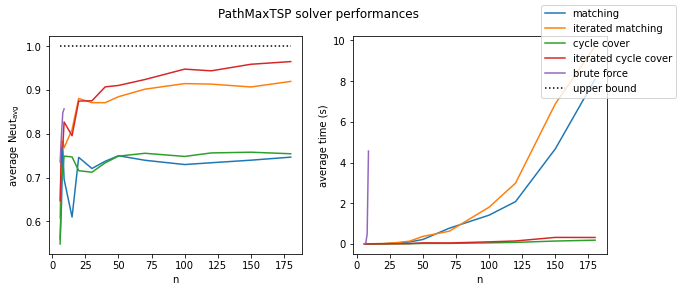

In [125]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('PathMaxTSP solver performances')

axes[0].plot(n_domain, neuts, label=solver_names)
axes[0].plot(n_domain, [1 for _ in n_domain], label='upper bound', color='black', linestyle=':')
axes[0].set_xlabel('n')
axes[0].set_ylabel(r'average $\operatorname{Neut}_{\operatorname{avg}}$')

# axes[0].set_xscale('log')

axes[1].plot(n_domain, times)
axes[1].set_xlabel('n')
axes[1].set_ylabel('average time (s)')

# axes[1].set_xscale('log')
# axes[1].set_yscale('log')

fig.legend()

plt.savefig("avg_agg_plots.png")

### min aggregation

In [110]:
solvers_ma = [
    min_agg, 
    via_brute_force_min_agg
]

solver_names_ma = [
    "heuristic method", 
    "brute force"
]

In [111]:
n_domain_ma = [6, 7, 8, 9, 15, 20, 30, 40, 50, 70]

In [112]:
# iterate over different values of n
neuts_ma = []
times_ma = []
for n in tqdm(n_domain_ma):
    Gs = []
    for i in range(iterations):
        Gs.append(nx.complete_graph(n))
        for (u,v) in Gs[i].edges:
            Gs[i].edges[u,v]['weight'] = random.random()
    
    # iterate over the different solvers
    inner_neuts = []
    inner_times = []
    for func in solvers_ma:
        if n > 10 and func == via_brute_force_min_agg:
            inner_neuts.append(None)
            inner_times.append(None)
            continue
        
        # iterate over the different random graphs
        inner_inner_neuts = []
        inner_inner_times = []
        for i in range(iterations):
            # take the best of `timeit_iterations` times to account for external performance factors
            time_min = math.inf
            for j in range(timeit_iterations):
                start = perf_counter()
                p = func(Gs[i], n)
                t = perf_counter() - start
                time_min = min(time_min, t)
            inner_inner_neuts.append(neutrality(Gs[i], p, min))
            inner_inner_times.append(time_min)
        inner_neuts.append(sum(inner_inner_neuts) / iterations)
        inner_times.append(sum(inner_inner_times) / iterations)
    neuts_ma.append(inner_neuts)
    times_ma.append(inner_times)

100%|███████████████████████████████████████████████████████████████| 10/10 [05:25<00:00, 32.59s/it]


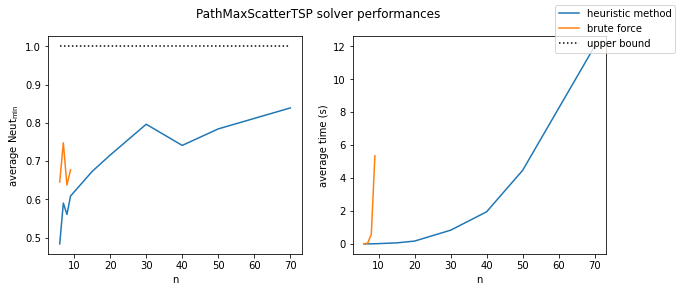

In [121]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('PathMaxScatterTSP solver performances')

axes[0].plot(n_domain_ma, neuts_ma, label=solver_names_ma)
axes[0].plot(n_domain_ma, [1 for _ in n_domain_ma], label='upper bound', color='black', linestyle=':')
axes[0].set_xlabel('n')
axes[0].set_ylabel(r'average $\operatorname{Neut}_{\min}$')

# axes[0].set_xscale('log')

axes[1].plot(n_domain_ma, times_ma)
axes[1].set_xlabel('n')
axes[1].set_ylabel('average time (s)')

# axes[1].set_xscale('log')
# axes[1].set_yscale('log')

fig.legend()

plt.savefig("min_agg_plots.png")